# 0. 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

learning_rate = 0.0002
gamma = 0.98
game_round = 10
strategies = ["Copycat", "All Cooperate", "All Cheat", "Grudger", "Detective", 
              "Copykitten", "Simpleton", "Random", "Cheat-Downing", "Cooperate-Downing", 
              "Joss", "Cheat-Tester", "Cooperate-Tester", "Tranquilizer", "Gradual", 
              "Prober", "Pavlov", "Mistrust", "Per-Kind", "Per-Nasty"]

# 1. State, Action, Reward에 관한 환경 설정

## 1-1. REINFORCE 알고리즘

In [ ]:
class REINFORCE(nn.Module):
    def __init__(self):
        super(REINFORCE, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(game_round * 2, 128)
        self.fc2 = nn.Linear(128, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x
      
    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):
        R = 0
        policy_loss = []
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + gamma * R
            loss = -torch.log(prob) * R
            policy_loss.append(loss.unsqueeze(0))
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        self.data = []

## 1-2. 점수 획득 규칙

In [ ]:
def reward(my_action, opponent_action):
    if [my_action, opponent_action] == [1, 1]: # 협력, 협력
        return 2
    elif [my_action, opponent_action] == [1, 0]: # 협력, 배신
        return -1
    elif [my_action, opponent_action] == [0, 1]: # 배신, 협력
        return 3
    elif [my_action, opponent_action] == [0, 0]: # 배신, 배신
        return 0

## 1-3. 상대방의 전략과 현재 게임 상태에 기반하여 상대방의 행동 선택

In [ ]:
class game():
    def reset():
        return [-1 for _ in range(game_round * 2)], strategies[random.randint(0, len(strategies)-1)]

    def step(state, strategy, my_action):
        my_state = []
        opp_state = []
        for i, s in enumerate(state):
            if s == -1:
                cur_game_round = i // 2
                break
            if i % 2 == 0:
                my_state.append(s)
            else:
                opp_state.append(s)

        if strategy == "Copycat":
            if cur_game_round == 0:
                opp_action = 1
            else:
                prev_my_action = my_state[-1]
                opp_action = prev_my_action

        elif strategy == "All Cooperate":
            opp_action = 1

        elif strategy == "All Cheat":
            opp_action = 0

        elif strategy == "Grudger":
            if cur_game_round == 0:
                opp_action = 1
            else:
                opp_action = 1 if 0 not in my_state else 0

        elif strategy == "Detective":
            if cur_game_round in [0, 2, 3]:
                opp_action = 1
            elif cur_game_round == 1:
                opp_action = 0
            else:
                if 0 in my_state[:4]:
                    prev_my_action = my_state[-1]
                    opp_action = prev_my_action
                else:
                    opp_action = 0

        elif strategy == "Copykitten":
            if cur_game_round in [0, 1]:
                opp_action = 1
            else:
                prev_prev_my_action, prev_my_action = my_state[-2], my_state[-1]
                opp_action = 0 if [prev_prev_my_action, prev_my_action] == [0, 0] else 1

        elif strategy == "Simpleton":
            if cur_game_round == 0:
                opp_action = 1
            else:
                prev_my_action, prev_opp_action = my_state[-1], opp_state[-1]
                if prev_my_action == 0:
                    if prev_opp_action == 0:
                        opp_action = 1
                    else:
                        opp_action = 0
                else:
                    opp_action = prev_opp_action

        elif strategy == "Random":
            opp_action = random.randint(0, 1)

        elif strategy == "Cheat-Downing":
            my_coop, my_cheat = 0, 0
            for ms in my_state:      
                if ms == 0:
                    my_cheat += 1
                else:
                    my_coop += 1
            if my_cheat >= my_coop:
                opp_action = 0
            else:
                opp_action = 1                

        elif strategy == "Cooperate-Downing":
            my_coop, my_cheat = 0, 0
            for ms in my_state:      
                if ms == 0:
                    my_cheat += 1
                else:
                    my_coop += 1
            if my_cheat > my_coop:
                opp_action = 0
            else:
                opp_action = 1
        
        elif strategy == "Joss":
            if cur_game_round == 0:
                prob = random.randint(0, 9)
                if prob == 0:
                    opp_action = 0
                else:
                  opp_action = 1
            else:
                prev_my_action = my_state[-1]
                opp_action = prev_my_action

        elif strategy == "Cheat-Tester":
            if cur_game_round < game_round // 2:
                opp_action = random.randint(0, 1)
            else:
                my_coop, my_cheat = 0, 0
                for i in range(game_round // 2):      
                    if my_state[i] == 0:
                        my_cheat += 1
                    else:
                        my_coop += 1
                if my_cheat >= my_coop:
                    opp_action = 0
                else:
                    opp_action = 1

        elif strategy == "Cooperate-Tester":
            if cur_game_round < game_round // 2:
                opp_action = random.randint(0, 1)
            else:
                my_coop, my_cheat = 0, 0
                for i in range(game_round // 2):      
                    if my_state[i] == 0:
                        my_cheat += 1
                    else:
                        my_coop += 1
                if my_cheat > my_coop:
                    opp_action = 0
                else:
                    opp_action = 1

        elif strategy == "Tranquilizer":
            opp_coop, opp_cheat = 0, 0
            for os in opp_state:
                if os == 0:
                    opp_cheat += 1
                else:
                    opp_coop += 1
            if (opp_cheat + 1) / (opp_coop + opp_cheat + 1) < 0.25:
                opp_action = 0
            else:
                opp_action = 1

        elif strategy == "Gradual":
            if cur_game_round == 0:
                  opp_action = 1
            else:
                my_cheat = 0
                for ms in my_state:
                    if ms == 0:
                        my_cheat += 1
                x, cheat_sum = 1, 0
                for mc in range(my_cheat):
                    cheat_sum += x
                    x += 1
                opp_cheat = 0
                for os in opp_state:
                    if os == 0:
                        opp_cheat += 1
                if cheat_sum > opp_cheat:
                    opp_action = 0
                else:
                    opp_action = 1

        elif strategy == "Prober":
            if cur_game_round in [0, 1, 2]:
                if cur_game_round == 0:
                    opp_action = 1
                else:
                    opp_action = 0
            else:
                prev_three_round = [3, 4, 5]
                while True:
                    if cur_game_round in prev_three_round:
                        for i in range(3):
                            prev_three_round[i] -= 3
                        break
                    else:
                        for i in range(3):
                            prev_three_round[i] += 3
                if my_state[prev_three_round[1]] == 1 and my_state[prev_three_round[2]] == 0:
                    opp_action = my_state[-1]
                else:
                    if cur_game_round % 3 == 0:
                        opp_action = 0
                    else:
                        opp_action = 1

        elif strategy == "Pavlov":
            if cur_game_round == 0:
                opp_action = 1
            else:
                if opp_state[-1] == my_state[-1]:
                    opp_action = 1
                else:
                    opp_action = 0
        
        elif strategy == "Mistrust":
            if cur_game_round == 0:
                opp_action = 0
            else:
                prev_my_action = my_state[-1]
                opp_action = prev_my_action

        elif strategy == "Per-Kind":
            if cur_game_round % 3 in [0, 1]:
                opp_action = 1
            else:
                opp_action = 0

        elif strategy == "Per-Nasty":
            if cur_game_round % 3 == 0:
                opp_action = 1
            else:
                opp_action = 0

        state[cur_game_round * 2] = my_action
        state[cur_game_round * 2 + 1] = opp_action

        return state, reward(my_action, opp_action), (-1 not in state) 

# 2. 강화학습

In [ ]:
model = REINFORCE()
score = 0.0
print_interval = 1000

X = []
Y = []
for n_epi in range(200000):
    s, opp_st = game.reset()
    done = False
    
    while not done:

        prob = model(torch.tensor(s).float())    
        m = Categorical(prob)
        a = m.sample()
        s_prime, r, done = game.step(s, opp_st, a)
        model.put_data((r,prob[a]))
        s = s_prime
        score += r
        
    model.train_net()
    
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {}".format(n_epi, score/print_interval))
        X.append(n_epi)
        Y.append(score/print_interval)
        score = 0.0

torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/model.pth')

# of episode :1000, avg score : 12.051
# of episode :2000, avg score : 13.123
# of episode :3000, avg score : 13.472
# of episode :4000, avg score : 13.877
# of episode :5000, avg score : 13.525
# of episode :6000, avg score : 13.805
# of episode :7000, avg score : 14.195
# of episode :8000, avg score : 14.139
# of episode :9000, avg score : 14.265
# of episode :10000, avg score : 14.354
# of episode :11000, avg score : 14.553
# of episode :12000, avg score : 14.581
# of episode :13000, avg score : 14.399
# of episode :14000, avg score : 14.109
# of episode :15000, avg score : 14.343
# of episode :16000, avg score : 14.59
# of episode :17000, avg score : 13.818
# of episode :18000, avg score : 14.236
# of episode :19000, avg score : 14.852
# of episode :20000, avg score : 14.412
# of episode :21000, avg score : 14.706
# of episode :22000, avg score : 14.809
# of episode :23000, avg score : 14.637
# of episode :24000, avg score : 14.692
# of episode :25000, avg score : 14.785
# of episo

# 3. 가장 우수한 전략과 점수 및 학습하는 동안 모델의 획득 점수 추이 그래프 표시

In [ ]:
best_score = -1
for strategy in strategies:
    score = 0
    for opp_strategy in strategies:
        if strategy == opp_strategy: continue
        state = [-1 for _ in range(game_round * 2)]
        done = False
        while not done:
            my_state = []
            opp_state = []
            for i, s in enumerate(state):
                if s == -1:
                    cur_game_round = i // 2
                    break
                if i % 2 == 0:
                    my_state.append(s)
                else:
                    opp_state.append(s)

            if strategy == "Copycat":
                if cur_game_round == 0:
                    my_action = 1
                else:
                    prev_opp_action = opp_state[-1]
                    my_action = prev_opp_action

            elif strategy == "All Cooperate":
                my_action = 1

            elif strategy == "All Cheat":
                my_action = 0

            elif strategy == "Grudger":
                if cur_game_round == 0:
                    my_action = 1
                else:
                    my_action = 1 if 0 not in opp_state else 0

            elif strategy == "Detective":
                if cur_game_round in [0, 2, 3]:
                    my_action = 1
                elif cur_game_round == 1:
                    my_action = 0
                else:
                    if 0 in opp_state[:4]:
                        prev_opp_action = opp_state[-1]
                        my_action = prev_opp_action
                    else:
                        my_action = 0

            elif strategy == "Copykitten":
                if cur_game_round in [0, 1]:
                    my_action = 1
                else:
                    prev_prev_opp_action, prev_opp_action = opp_state[-2], opp_state[-1]
                    my_action = 0 if [prev_prev_opp_action, prev_opp_action] == [0, 0] else 1

            elif strategy == "Simpleton":
                if cur_game_round == 0:
                    my_action = 1
                else:
                    prev_action, prev_opp_action = my_state[-1], opp_state[-1]
                    if prev_opp_action == 0:
                        if prev_action == 0:
                            my_action = 1
                        else:
                            my_action = 0
                    else:
                        my_action = prev_action

            elif strategy == "Random":
                my_action = random.randint(0, 1)

            elif strategy == "Cheat-Downing":
                opp_coop, opp_cheat = 0, 0
                for os in opp_state:      
                    if os == 0:
                        opp_cheat += 1
                    else:
                        opp_coop += 1
                if opp_cheat >= opp_coop:
                    my_action = 0
                else:
                    my_action = 1                

            elif strategy == "Cooperate-Downing":
                opp_coop, opp_cheat = 0, 0
                for os in opp_state:      
                    if os == 0:
                        opp_cheat += 1
                    else:
                        opp_coop += 1
                if opp_cheat > opp_coop:
                    my_action = 0
                else:
                    my_action = 1
            
            elif strategy == "Joss":
                if cur_game_round == 0:
                    prob = random.randint(0, 9)
                    if prob == 0:
                        my_action = 0
                    else:
                      my_action = 1
                else:
                    prev_opp_action = opp_state[-1]
                    my_action = prev_opp_action

            elif strategy == "Cheat-Tester":
                if cur_game_round < game_round // 2:
                    my_action = random.randint(0, 1)
                else:
                    opp_coop, opp_cheat = 0, 0
                    for i in range(game_round // 2):      
                        if opp_state[i] == 0:
                            opp_cheat += 1
                        else:
                            opp_coop += 1
                    if opp_cheat >= opp_coop:
                        my_action = 0
                    else:
                        my_action = 1

            elif strategy == "Cooperate-Tester":
                if cur_game_round < game_round // 2:
                    my_action = random.randint(0, 1)
                else:
                    opp_coop, opp_cheat = 0, 0
                    for i in range(game_round // 2):      
                        if opp_state[i] == 0:
                            opp_cheat += 1
                        else:
                            opp_coop += 1
                    if opp_cheat > opp_coop:
                        my_action = 0
                    else:
                        my_action = 1

            elif strategy == "Tranquilizer":
                my_coop, my_cheat = 0, 0
                for ms in my_state:
                    if ms == 0:
                        my_cheat += 1
                    else:
                        my_coop += 1
                if (my_cheat + 1) / (my_coop + my_cheat + 1) < 0.25:
                    my_action = 0
                else:
                    my_action = 1

            elif strategy == "Gradual":
                if cur_game_round == 0:
                      my_action = 1
                else:
                    opp_cheat = 0
                    for os in opp_state:
                        if os == 0:
                            opp_cheat += 1
                    x, cheat_sum = 1, 0
                    for oc in range(opp_cheat):
                        cheat_sum += x
                        x += 1
                    my_cheat = 0
                    for ms in my_state:
                        if ms == 0:
                            my_cheat += 1
                    if cheat_sum > my_cheat:
                        my_action = 0
                    else:
                        my_action = 1

            elif strategy == "Prober":
                if cur_game_round in [0, 1, 2]:
                    if cur_game_round == 0:
                        my_action = 1
                    else:
                        my_action = 0
                else:
                    prev_three_round = [3, 4, 5]
                    while True:
                        if cur_game_round in prev_three_round:
                            for i in range(3):
                                prev_three_round[i] -= 3
                            break
                        else:
                            for i in range(3):
                                prev_three_round[i] += 3
                    if opp_state[prev_three_round[1]] == 1 and opp_state[prev_three_round[2]] == 0:
                        my_action = opp_state[-1]
                    else:
                        if cur_game_round % 3 == 0:
                            my_action = 0
                        else:
                            my_action = 1

            elif strategy == "Pavlov":
                if cur_game_round == 0:
                    my_action = 1
                else:
                    if my_state[-1] == opp_state[-1]:
                        my_action = 1
                    else:
                        my_action = 0
            
            elif strategy == "Mistrust":
                if cur_game_round == 0:
                    my_action = 0
                else:
                    prev_opp_action = opp_state[-1]
                    my_action = prev_opp_action

            elif strategy == "Per-Kind":
                if cur_game_round % 3 in [0, 1]:
                    my_action = 1
                else:
                    my_action = 0

            elif strategy == "Per-Nasty":
                if cur_game_round % 3 == 0:
                    my_action = 1
                else:
                    my_action = 0

            s_prime, r, done = game.step(state, opp_strategy, my_action)
            done_mask = 0.0 if done else 1.0
            state = s_prime
            score += r
            if done:
                break
    
    if score / (len(strategies)-1) > best_score:
        best_strategy = strategy
        best_score = score / (len(strategies)-1)
    print("strategy: {}, score: {}".format(strategy, score / (len(strategies)-1)))

strategy: Copycat, score: 14.631578947368421
strategy: All Cooperate, score: 12.578947368421053
strategy: All Cheat, score: 9.473684210526315
strategy: Grudger, score: 12.368421052631579
strategy: Detective, score: 12.789473684210526
strategy: Copykitten, score: 14.0
strategy: Simpleton, score: 13.31578947368421
strategy: Random, score: 10.421052631578947
strategy: Cheat-Downing, score: 10.473684210526315
strategy: Cooperate-Downing, score: 13.578947368421053
strategy: Joss, score: 13.894736842105264
strategy: Cheat-Tester, score: 13.105263157894736
strategy: Cooperate-Tester, score: 11.421052631578947
strategy: Tranquilizer, score: 12.368421052631579
strategy: Gradual, score: 14.157894736842104
strategy: Prober, score: 9.68421052631579
strategy: Pavlov, score: 12.105263157894736
strategy: Mistrust, score: 9.052631578947368
strategy: Per-Kind, score: 12.263157894736842
strategy: Per-Nasty, score: 9.736842105263158


Best strategy is : Copycat
Best score is : 14.631578947368421
Max Avg Score is : 16.959


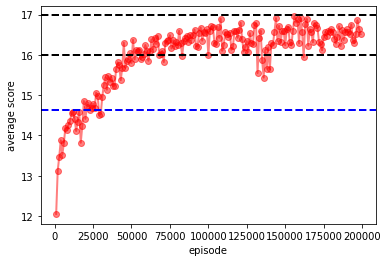

In [ ]:
print('Best strategy is : ' + str(best_strategy))
print('Best score is : ' + str(best_score))

import matplotlib.pyplot as plt

def line_plot(X, Y, target):
    plt.plot(X, Y, color='red', marker='o', alpha=0.5, linewidth=2)

    plt.xlabel("episode")
    plt.ylabel("average score")
    print('Max Avg Score is : ' + str(max(Y)))
    plt.axhline(target, color='blue', linestyle='--', linewidth=2)
    plt.axhline(16, color='black', linestyle='--', linewidth=2)
    plt.axhline(17, color='black', linestyle='--', linewidth=2)
    plt.show()

line_plot(X, Y, best_score)

# 4. 전략 별로 모델의 대응 및 획득 점수 표시

In [ ]:
def test(agent, state):
    prob = agent(torch.tensor(state).float())
    return int(torch.argmax(prob))

In [ ]:
agent = REINFORCE()
agent.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/model.pth'))

<All keys matched successfully>

In [ ]:
for strategy in strategies:
    score = 0
    state = [-1 for _ in range(game_round * 2)]
    done = False
    while not done:
        my_action = test(agent, state)
        s_prime, r, done = game.step(state, strategy, my_action)
        state = s_prime
        score += r
        if done:
            break

    opp_score = 0
    for i in range(game_round * 2):
        if i % 2 == 1: continue
        opp_score += reward(state[i+1], state[i])
    
    print("vs {}, score: {}, opp_score: {}".format(strategy, score, opp_score))
    print("state: {}".format(state))
    print(" ")

vs Copycat, score: 21, opp_score: 17
state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs All Cooperate, score: 21, opp_score: 17
state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs All Cheat, score: -3, opp_score: 9
state: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 
vs Grudger, score: 21, opp_score: 17
state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs Detective, score: 10, opp_score: 10
state: [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
 
vs Copykitten, score: 21, opp_score: 17
state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs Simpleton, score: 21, opp_score: 17
state: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs Random, score: 4, opp_score: 12
state: [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 
vs Cheat-Downing, score: 18, opp_score: 18
state: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
 
vs Cooperate-Downin